# Classification with Logistic Regression

In today's exercise, we'll introduce **logistic regression** as a mechanism for performing _classification tasks_. This exercise walks through a conceptual example discussd in chapter 4 of [this book](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf), and the data was extracted from the `ISLR` R package (specifically, the `Default` dataset). The question of interest for this exercise is, 

> Can we predict which individuals will default on their credit card payments?


# Set Up (0 minutes)

In [4]:
# Set up
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
from scipy.stats import ttest_ind # t-tests
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics
matplotlib.style.use('ggplot')
%matplotlib inline

# Altair is not included because it can't render more than 5,000 points (this data has 10,000)

# Load the data, replace strings as numeric
df = pd.read_csv('./data/payment-default.csv')
df.default = df.default.replace(['Yes', 'No'], [1, 0]).astype(int)
df.student = df.student.replace(['Yes', 'No'], [1, 0]).astype(int)

# Data Exploration (15 minutes)

In this first section, you'll explore your dataset to get a better handle on the distributions. The data for this exercise has **10,000** observations (people), who did, or did not, default on their credit card payment. The data has the following information for each person:

- `default`: This is our **outcome** of interest, and is **binary** (yes/no)
- `student`: This variable indicates if each person is a students (yes/no)
- `balance`: Current balance on the credit card (**continuous**)
- `income`: Annual income of the individual (**continuous**)

In this section, you'll write the code necessary to answer the following questions:

- What is the **default rate** in the dataset (# of defaults / total)
- What is the distribution of credit card **balances** (for those who default, and those who do not)?
- What is the relationship between `balance` and `income` (show a scatter-plot, different colors for default/no default)?


In [5]:
# What is the **default rate** in the dataset (# of defaults / total)

default = df[['default']]
total = default.groupby('default').size()
total = total[1]
default_rate = total/10000 * 100

print(default_rate)

3.3300000000000005


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


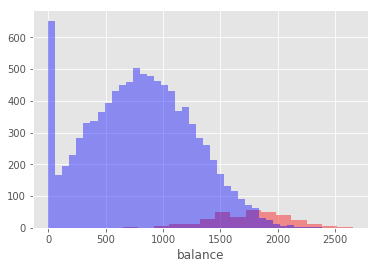

In [6]:
# What is the distribution of balances (for those who default, and those who don't)?

# You may want to create subsets of the data for those who defaulted, and those who did not
default=df.loc[df['default'] == 1]
nodefault=df.loc[df['default'] == 0]

# Draw histograms of the distribution (perhaps overlapping histogram on the same chart)
sns.distplot(default['balance'],hist=True, kde=False, color = 'red')
sns.distplot(nodefault['balance'],hist=True, kde=False, color = 'blue')



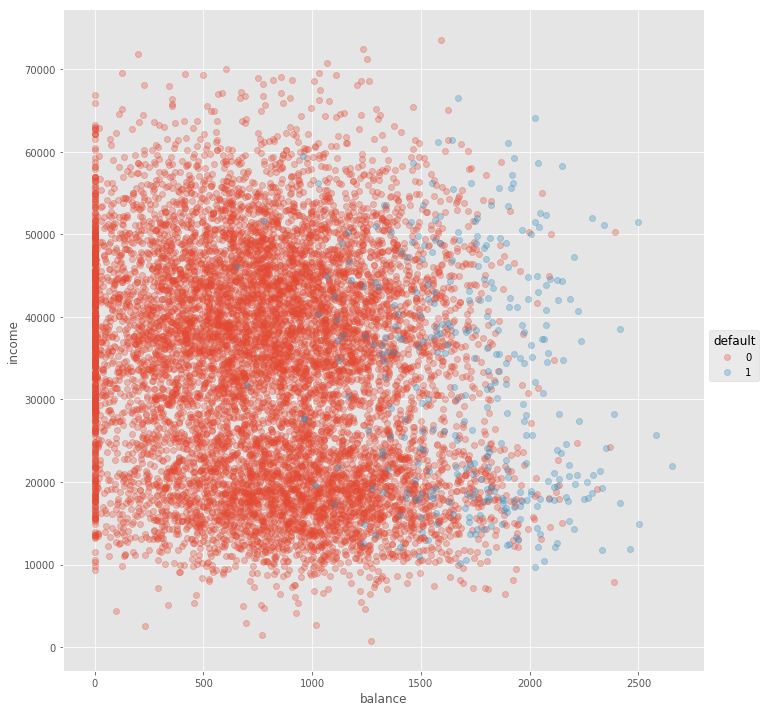

In [7]:
# What is the relationship between balalance and income 
# Show a scatter-plot with different colors for default/no default
# You can use `sns.lmplot()`, `df.plot()`, or other options 
sns.lmplot(x="balance", y="income", hue="default", data=df, fit_reg=False, scatter_kws={'alpha':0.3}, size = 10)

List pertinent observations from the above analysis:

> There is a wider spread of those who did not default than those who did default.


# A Linear Approach (15 minutes)

Before introducing a new estimation approach, we'll observe the limitations of using a linear estimation of a binary outcome. In this section, you'll do the following:

- Fit a **linear model** of the dependent variable (`default`) on _one_ indepdendent variable (`balance`)
- Generate predictions using your model (this can be interpreted as _probability of default_)
- Visualize the results (comparing `balance` to the predicted `default` rate)
- Interpret the **coefficients** and assess the **model fit**

In [8]:
# Fit a linear model of the dependent variable (default) on balance
balance_df = df["balance"]
default_df = df["default"]
X = balance_df
y = default_df

model = sm.OLS(y, X).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1225.
Date:                Wed, 31 Oct 2018   Prob (F-statistic):          2.38e-253
Time:                        14:23:13   Log-Likelihood:                 3399.6
No. Observations:               10000   AIC:                            -6797.
Df Residuals:                    9999   BIC:                            -6790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
balance     6.246e-05   1.78e-06     35.006      0.000     5.9e-05     6.6e-05
==============================================================================
Omnibus:                     9623.908   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           274381.704
Skew:                           4.984   Prob(JB):                         0.00
Kurtosis:                      26.647   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# Generate predictions using your model (this can be interpreted as probability of default)
predictions = model.predict()
df['predictions']=predictions


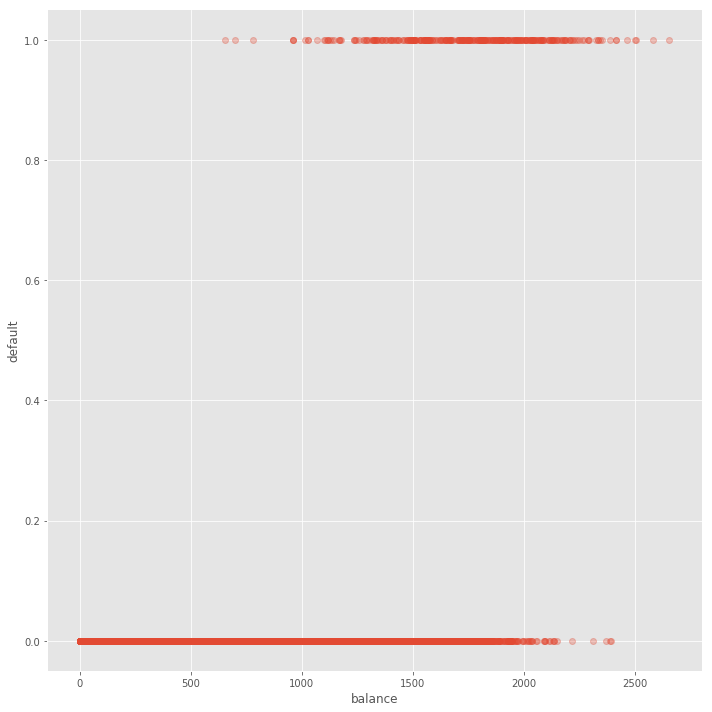

In [10]:
# Visualize the results: scatterplot of balance v.s. predcited default rate. Bonus: add actual default rate.
sns.lmplot(x="balance", y="default", data=df, fit_reg=False, scatter_kws={'alpha':0.3}, size = 10);


What is your interpretation of the coefficients and your assessment of the model fit?

> The coefficient of 6.246e-05 represents an increase of 6.246e-05 per each unit in balance. My assessment of the model aligns with this. 

# The Logistic Function (10 minutes)

For this section, you'll simply familiarize yourself with the **Logistic Function**. In order to perform **classification**, we want to explicitly **model the probability** of falling into each category. Given the limitations of linear regression, we want to find a functional form with the following property:

> _All values output by the function should fall **between 0 and 1**._

Because we are modeling **conditional probability**, we will annotate our formula using the following shorthand:

\begin{equation*}
p(X)= Pr\left(Y=1|X\right) \\
\end{equation*}

\begin{equation*}
p(balance)=Pr(default=1|balance)
\end{equation*}

While there are many functions that meet this requirement, a commonly used formula (and the one that we will use for logistic regression) is the **logistic function**:


\begin{equation*}
p(X) = \frac { { e }^{ { { B }_{ 0 } } + { B }_{ 1 }X } }{ 1+{ e }^{ { { B }_{ 0 } } + { B }_{ 1 }X}} 
\end{equation*}

Note, with some manipulaiton, we can rearrange the above equation into the following equality:

\begin{equation*}
\frac { p(X) }{ 1 - p(X) } = { e }^{ { { B }_{ 0 } }+{ B }_{ 1 }X } 
\end{equation*}

As you may have noticed, the left hand side of the equation is the **odds** of observing our dependent variable given our independent variable(s). This is because the odds is the ratio of the probability of an event, $p(X)$, relative to the probability of not observing the event, $1 - p(X)$.

By simply taking the log of both sides of the above equation, we arrive at the following formula:

\begin{equation*}
\log \left( { \frac { p(X) }{ 1-p(X) } }\right) ={ { B }_{ 0 } }+{ B }_{ 1 }X
\end{equation*}

On the left-hand side of the equation, we are left with the _log odds_, or _logit_, that has a **linear relationship** with the predictor variables. The betas are estimated using **maximum likelihood methods**, which are beyond the scope of this course. However, the intuition of this approach is that you are "finding the set of parameters for which the probability of the observed data is greatest" ([source](http://czep.net/stat/mlelr.pdf)). 

Logistic models will generate a set of probabilities of an observation being a 0 or a 1. Given the functional form, the default threshold for classification is .5 (i.e., if a probability is less than .5, the model predicts it is _not_ a positive case). 

# Running a Logistic Regression (15 minutes)

We'll continue to use the `statsmodels.formula.api` to write R style formulas in our analytical approaches. Logistic Regression is considered a **Generalized Linear Model**, which is described well on [Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model):

> The generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models **other than a normal distribution**.

This class of models extends the linear model in a variety of ways, while providing an API that resembles the linear approach. 

In this section, you should: 

- Use the `smf.glm` function to fit `default` to `balance` (hint: see this [example](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/glm_formula.html))
- Generate a set of predicted probabilities using your model
- Visualize the predicted probabilities across balances


In [11]:
# Use the `smf.glm` function to fit `default` to `balance` (hint: use the `binomial` family)
formula = 'default~balance'
dataset = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
dataset.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -798.23
Date:                Wed, 31 Oct 2018   Deviance:                       1596.5
Time:                        14:23:18   Pearson chi2:                 7.15e+03
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0.000     24.952      0.000       0.005       0.006
==============================================================================
"""

In [12]:
# Generate a set of predicted probabilities using your model
predict = dataset.predict()
df['predict'] = predict

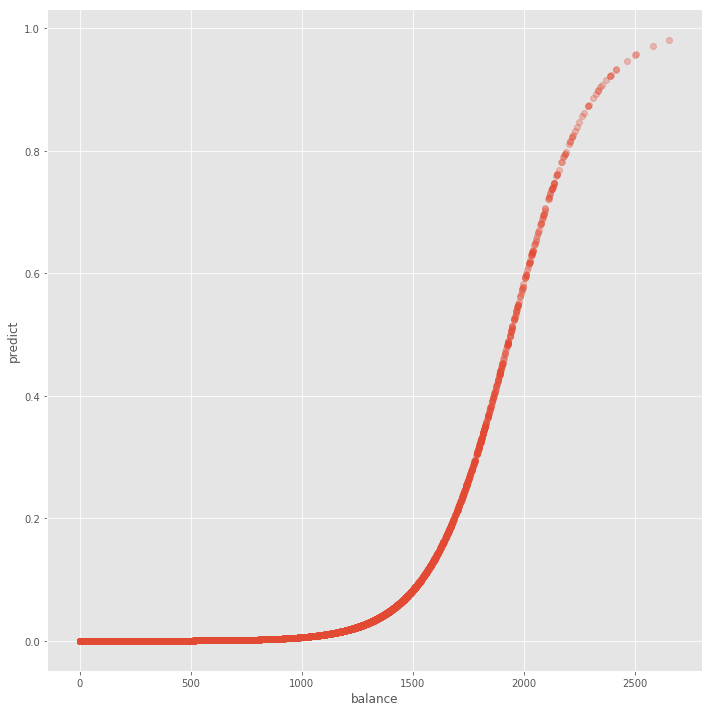

In [34]:
# Visualize the predicted probabilities across balances (bonus: add the observed values as well)
sns.lmplot(x="balance", y="predict", data=df, fit_reg=False, scatter_kws={'alpha':0.3}, size = 10);


While the simplicity of the `predict()` method makes it easy to overlook the interworkings of the model. You should note that the estimates are generated by plugging values of $X$ into this equation (with your estimated Beta values):

\begin{equation*}
p(X) = \frac { { e }^{ { { B }_{ 0 } } + { B }_{ 1 }X } }{ 1+{ e }^{ { { B }_{ 0 } } + { B }_{ 1 }X}} 
\end{equation*}

# Interpreting Betas (15 minutes)

As demonstrated above, the logistic formula is **linear in logit space**. This means that changes in your variables are associated with a **change in the log odds** of your dependent variable. There are a few implications of this:

- **P-Values** retain their same interpretation (probability of observing the relationship _by chance_), and can be used to confirm/reject the null hypothesis
- **Direction** of betas (+/-) is associated with a corresponding increase/decrease in the _log odds_ of the outcome. This can be interpreted as a positive / negative relationship. 

## Units
**Units** of the betas are more difficult to interpret. Each unit increase in $X$ is _associated with_ an increase in the **log odds** of the dependent variable $Y$. As you can see in the curve above, increases in log odds are **multiplicative** in nature. This means that a unit increase in $X$ corresponds to a **different** change in $Y$ depending on your **current value of $X$** (see how the **slope** of the curve changes). However, if we **exponentiate the beta value**, we can also describe proportional increase in the **odds** (not just the increase in _log odds_). Consider the following formulas for calculating the log odds for ${X}_{i}$ and ${X}_{i - 1}$ (a unit increase in $X$):

\begin{equation*}
LogOddsX_{i} = \log \left( { \frac { p({X}_{i}) }{ 1-p({X}_{i}) } }\right) ={ { B }_{ 0 } }+{ B }_{ 1 }{X}_{i}
\end{equation*}

\begin{equation*}
LogOddsX_{i-1} = \log \left( { \frac { p({X}_{i-1}) }{ 1-p({X}_{i-1}) } }\right) ={ { B }_{ 0 } }+{ B }_{ 1 }{X}_{i-1}
\end{equation*}

Because of the **linear relationship** in logit space, we can then easily calculate the **difference** in log odds between ${X}_{i}$ and ${X}_{i + 1}$ as $B_{1}$:

\begin{equation*}
\log \left( { \frac { p({X}_{i}) }{ 1-p({X}_{i}) } }\right) - \log \left( { \frac { p({X}_{i-1}) }{ 1-p({X}_{i-1}) } }\right) = {B}_{1}
\end{equation*}

If we exponentiate each side of the equation, we can see that the **proportional increase in odds** betweeen $P(X_{i-1})$ and $P(X_{i})$ is simply ${e}^{{B}_{1}}$:

\begin{equation*}
\frac { \left( { \frac { p({ X }_{ i }) }{ 1-p({ X }_{ i }) }  } \right)  }{ \left( { \frac { p({ X }_{ i-1 }) }{ 1-p({ X }_{ i-1 }) }  } \right)  } ={ e }^{ B_{ 1} }
\end{equation*}

We can then interpret the **exponentiated beta value** as the observed **multiplicative unit increase in odds** in the dependent variable.

In the section below, you should get the `summary` of your logistic model to retrieve betas values from your model.

In [14]:
# Retrieve beta values from the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1225.
Date:                Wed, 31 Oct 2018   Prob (F-statistic):          2.38e-253
Time:                        14:23:28   Log-Likelihood:                 3399.6
No. Observations:               10000   AIC:                            -6797.
Df Residuals:                    9999   BIC:                            -6790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
balance     6.246e-05   1.78e-06     35.006      0.000     5.9e-05     6.6e-05
==============================================================================
Omnibus:                     9623.908   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           274381.704
Skew:                           4.984   Prob(JB):                         0.00
Kurtosis:                      26.647   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using the beta values produced by the model, describe the relationship between `balance` and `default` (make sure to note the **p-value**, **direction**, and **units** of the coefficient):

> - **P Value**: at 97.5% confidence, p-value is .006.
> - **Direction**:negative
> - **Units**: dollars ($)

# A More Interpretable Model (10 minutes)

The proportional increase of .6% in the model above is a bit small to have a good intuitive sense of. However, we can easily change our units of analysis to make this more interpretable. In the section below, you should do the following:

- Convert balance to units of \$100 and re-run the regression (hint, you'll need to create a new column or copy your dataframe)
- Extract the beta value for balance and interpret how an increase of your balance (by \$100) is associated with the odds of defaulting

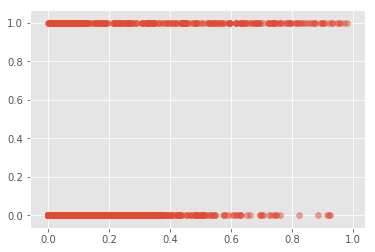

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -798.23
Date:                Wed, 31 Oct 2018   Deviance:                       1596.5
Time:                        15:35:11   Pearson chi2:                 7.15e+03
No. Iterations:                     9   Covariance Type:             nonrobust
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -10.6513      0.361    -29.491      0.000     -11.359      -9.943
new_balance     0.5499      0.022     24.952      0.000       0.507       0.593
===============================================================================
"""

In [33]:
# Convert balance to units of $100 and re-run the regression
new_balance = df["balance"]/100
df['new_balance'] = new_balance

new_formula = 'default~new_balance'
new_model = smf.glm(formula=new_formula, data=df, family=sm.families.Binomial()).fit()
new_model.summary()
predict = new_model.predict()
df['predict'] = predict

x = df['predict']
y = df['default']
plt.scatter(x, y, alpha=0.5 )
plt.show()
new_model.summary()

What is the interpretation of your beta value from your regression?

> Since the coefficient is high, there is a higher chance of default per unit increase

# Evaluation Metrics (10 minutes)

In the section above, you've developed a strategy for interpreting the **betas** produced by your model. However, you also need to assess how well your model fits your data. In order to do this, we need to return to the purpose of our model. We want to **predict if people will default on their loans**. Before diving back into the code, we'll introduce a **confusion matrix** to represent the relationship between the data and our estimates.

## Sensitivity and Specificity
The concepts of sensitivity and specificity express how well your model accurately predicts positive and negative classes. In order to compute these, it is easy to first build a **confusion matrix** to show the total number of cases that were accurately predicted (and those that were not).

  <table>
  <tr>
    <td/>
    <td/>
    <td colspan="2"><em>Predicted Class</em></td>
  </tr>
  <tr>
    <td/>
    <td/>
    <td><strong>Negative (-)</strong></td>
    <td><strong>Positive (+)</strong></td>
    <td><strong>Total</strong></td>
  </tr>
  <tr>
    <td rowspan="2"><em>True Class</em></td>
    <td><strong>Negative (-)</strong></td>
    <td>True Negative (TN)</td>
    <td>False Positives (FP)</td>
    <td>Total non-cases (N)</td>
  </tr>
  <tr>
    <td><strong>Positive (+)</strong></td>
    <td>False Negatives (FN)</td>
    <td>True Positives (TP)</td>
    <td>Total cases (P)</td>
  </tr>
</table>


In the matrix above, the rows represent the **data**, while the columns represent the **predictions**. For example, the top left cell (_True Negatives_) represents the number of instances in which someone did not default, and the model predicted that they did not default. Here are the definitions of each cell:

- **True Positives**: The instances in which your model **predicts** a case (and the case **is true** in the data)
- **False Positives**: The instances in which your model **predicts** a case (and the case **is not** true in the data)
- **False Negatives**: The instances in which your model **does not** predict a case (and the case **is true** in the data)
- **True Negatives**: The instances in which your model **does not** predict a case (and the case **is not** true in the data)

Using those values, we can compute the **sensitivity** and **specificity** of our model:

\begin{equation*}
Sensitivity = \frac { True Positives }{ True Positives+False Negatives } 
\end{equation*}

\begin{equation*}
Specificity = \frac { TrueNegatives }{ TrueNegatives+FalsePositives } 
\end{equation*}

These two metrics lend important insights regarding the quality of our model:

> _**Sensitivity**_, also referred to as the _true positive rate_, tells us, of all of the **cases in the data**, how many did we accurately predict? This indicates the model's **ability to detect cases**. In other words, how **sensitively** does the model pick up on cases?

> _**Specificity**_, also referred to as the _true negative rate_, tells us, of all of the **non-cases in the data**, how many did we accurately predict? This indicates the model's ability to assign non-cases.

These metrics are directly used to calculate **Type I and Type II error rate**, which are analagous to Type I and Type II errors in statistical tests (incorrectly reject a true null hypothesis, incorrectly accept a false null hypothesis). 

> **Type I Error** rate is the proportion of instances which are **incorrectly classified as positive cases** (relative to the total number of **negative cases**). It is calculated as $1-specificity$, or simply the false positives relative to the total non-cases in the data, $FP/N$.

> **Type II Error** rate is the proportion of instances which are **incorrectly classified as negative cases** (relative to the total number of **positive cases**). It is calculated as $1-sensitivity$, or simply the false negatives relative to the total cases in the data, $FN/P$.


# Metric Calculation (15 minutes)

In this section, you'll evaluate the fit of your model by calculating the following:

- First, using a threshold of .5, use your model to predict a binary outcome (each case as 0 or 1)
- What is the **accuracy** of your model (how often does the prediction match the data)?
- What are the sensitivity, specificity, Type I error rate, and Type II error rates?

In [23]:
# First, using a threshold of .5, use your model to predict a binary outcome (each case as 0 or 1)
df['newest_prediction'] = np.where(df.predict > .5, 1, 0)
df['newest_prediction']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
9970    0
9971    0
9972    0
9973    0
9974    0
9975    0
9976    0
9977    0
9978    1
9979    0
9980    0
9981    0
9982    0
9983    0
9984    0
9985    0
9986    0
9987    0
9988    0
9989    0
9990    0
9991    0
9992    0
9993    0
9994    0
9995    0
9996    0
9997    0
9998    0
9999    0
Name: newest_prediction, Length: 10000, dtype: int64

In [24]:
# What is the accuracy of your model (how often does the prediction match the data)?
(df['default'] == df['newest_prediction']).count


<bound method Series.count of 0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
9970    True
9971    True
9972    True
9973    True
9974    True
9975    True
9976    True
9977    True
9978    True
9979    True
9980    True
9981    True
9982    True
9983    True
9984    True
9985    True
9986    True
9987    True
9988    True
9989    True
9990    True
9991    True
9992    True
9993    True
9994    True
9995    True
9996    True
9997    True
9998    True
9999    True
Length: 10000, dtype: bool>

In [25]:
# What are the sensitivity, specificity, Type I error rate, and Type II error rates?

# Sensitivity, specificity, and error rates


default_ans = df['default']
pred = df['newest_prediction']

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(default_ans, pred)
print(confusion_matrix)

# create variables for what goes into confusion matrix
true_pos = confusion_matrix[1,1]
true_neg = confusion_matrix[0,0]
false_pos = confusion_matrix[0,1]
false_neg = confusion_matrix[1,0]

# Sensitivity, specificity, and error rates

sensitivity = true_pos / (true_pos + false_neg)
specificity = true_neg / (true_neg + false_pos)

error_1 = 1 - sensitivity
error_2 = 1 - specificity


[[9625   42]
 [ 233  100]]


What is your interpretation of these values?

> Sensitivity is the true positive rate of how many positives were accurately predicted, which 30% were.
> Specificity shows how many negatives were accurately predicted shows 99% were accurate. 
> The error rate 1 shows proportion of when events are incorrectly classified as positive, and error rate 2 shows proportion of when events are incorrectly classified as negative.

## ROC Curve (10 minutes)

It is common to compare the _true positive rate_ (sensitivity) to the _false positive rate_ (1 - specificity) at each **threshold** for classification in an [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). This [interactive visualization](http://www.navan.name/roc/) may help you better understand the relationship between thresholds and the ROC. In this section, you'll do the following:

- Generate data for the ROC curve using the `metrics.roc_curve` function
- Draw your ROC curve
- Calculate the area under your ROC curve using the `metrics.roc_auc_curve` function

In [28]:
# Generate data for the ROC curve using the `metrics.roc_curve` function
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(default_ans, predict)


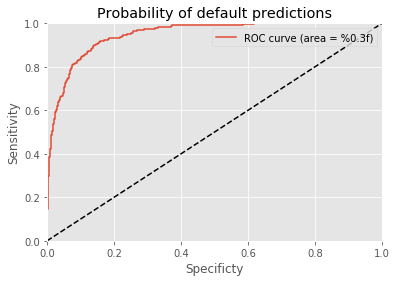

In [32]:
# Draw your ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificty')
plt.ylabel('Sensitivity')
plt.title('Probability of default predictions')
plt.legend(loc="upper right")

In [30]:
# Calculate the area under your ROC curve using the metrics.roc_auc_curve function
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(default_ans, pred)
roc

0.647977811265284